In [1]:
import sys
sys.path.append('./../../designer/script/')
import os
from gets.get_spectrum import get_spectrum_simple
from design import DesignSimple
from design import DesignForSpecSimple
from film import FilmSimple
from spectrum import Spectrum
from utils.plot_spectrum import plot_spectrum
from utils.load_designs import load_designs_single_spec, init_film_single_spec
from utils.sort import sort_by_ith_list
import numpy as np
import copy
from utils.loss import calculate_RMS
import matplotlib.pyplot as plt

num = 500
WLS = np.linspace(400, 1200, num)
sp = np.ones(num, dtype=float)

target_spectrum_reflection = Spectrum(0., WLS, sp)

In [2]:
def load_designs_for_spec(fpath, run_num, target_spec: Spectrum, n_A, n_B, n_sub, n_inc='Air') -> list[DesignForSpecSimple]:
    inc_ang = target_spec.INC_ANG
    wls = target_spec.WLS
    
    designs = []
    for i in range(run_num):
        d_init = np.loadtxt(fpath + f'run_{i}/init') * 1000
        f_init = FilmSimple(n_A, n_B, n_sub, d_init, n_inc)
        f_init.add_spec_param(inc_ang, wls)
        f_init.calculate_spectrum()

        d_final = np.loadtxt(fpath + f'run_{i}/final') * 1000
        f = FilmSimple(n_A, n_B, n_sub, d_final, n_inc)
        f.add_spec_param(inc_ang, wls)
        f.calculate_spectrum()
        
        design = DesignForSpecSimple(target_spec, f_init, f)
        designs.append(design)
        
    return designs

fpath = './../raw_design_result/50iters_0to5mum_reflection_400-1200/'
designs_TiO2 = load_designs_for_spec(fpath, 200, target_spectrum_reflection, 'TiO2', 'SiO2', 'SiO2')

c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


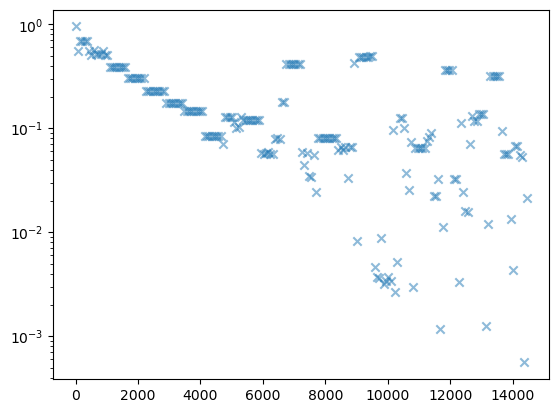

In [22]:
init_ots = []
final_ots = []
loss = []

for design in designs_TiO2:
    loss.append(design.calculate_loss())
    init_ots.append(design.get_init_ot())
    final_ots.append(design.get_current_ot())
loss = np.array(loss)


fig, ax = plt.subplots(1, 1)
ax.scatter(init_ots, loss, marker='x', alpha=0.5)

ax.set_yscale('log')

0.9027592156657807


'\nThis is a well designed film. Many other runs are trapped in local minimums.\nSharp transmission only occurs in samll wl region\nLayer structure similar to that of back-reflectors (run #120), \nor "modulated" ones as proposed in (run #198)\n    J. Krc, M. Zeman, S. L. Luxembourg, and M. Topic , "Modulated photonic-crystal structures as broadband back reflectors in thin-film solar cells", \n    Appl. Phys. Lett. 94, 153501 (2009) https://doi.org/10.1063/1.3109781\n'

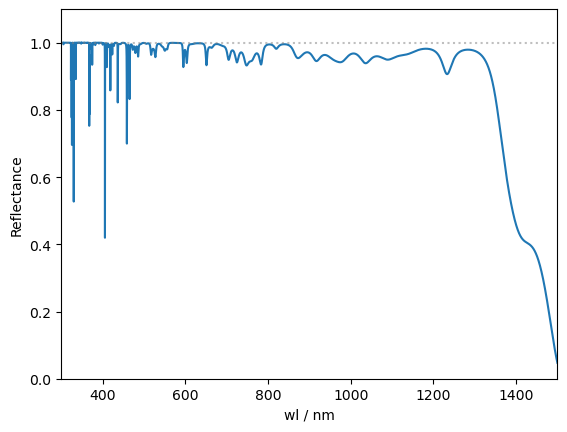

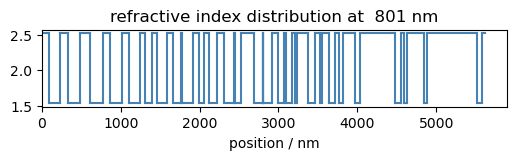

In [19]:

f = designs_TiO2[160].film

wls_new = np.linspace(300, 1500, 10000)
f.add_spec_param(0., wls_new)
f.calculate_spectrum()
spec = f.get_spec(0., wls_new).get_R()


fig, ax = plt.subplots(1, 1)
ax.plot(wls_new, spec)
ax.plot([wls_new[0], wls_new[-1]], [1, 1], ls=':', c='grey', alpha=0.5)
ax.set_ylabel('Reflectance')
ax.set_xlabel('wl / nm')
ax.set_ylim(0, 1.1)
ax.set_xlim(wls_new[0], wls_new[-1])


AUC = spec.mean() * (wls_new[-1] - wls_new[0])
eff = AUC / (wls_new[-1] - wls_new[0])

print(eff)


from utils.structure import plot_layer_thickness

plot_layer_thickness(f)

'''
- This is a well designed film. Many other runs are trapped in local minimums.

- Sharp transmission only occurs in samll wl region

- Layer structure similar to that of back-reflectors (run #120), 
or "modulated" ones as proposed in (run #198)
    J. Krc, M. Zeman, S. L. Luxembourg, and M. Topic , "Modulated photonic-crystal structures as broadband back reflectors in thin-film solar cells", 
    Appl. Phys. Lett. 94, 153501 (2009) https://doi.org/10.1063/1.3109781

- Deep inside the film, less ordered
'''

